# Mean Shift Model

### Import packages and data

In [2]:
import pandas as pd
import numpy as np
from sklearn.neighbors import DistanceMetric
import warnings
warnings.simplefilter("ignore")
import scipy.cluster.hierarchy as shc
%matplotlib inline

#from sklearn.metrics import silhouette_score, homogeneity_completeness_v_measure

#import matplotlib.pyplot as plt
#from scipy.cluster import hierarchy
#from scipy.spatial import distance

# Mean Shift 
from sklearn.cluster import MeanShift, estimate_bandwidth

In [74]:
data = pd.read_csv('Data/customer_data.csv')
del data["Unnamed: 0"]
del data["UniqueID"]

In [75]:
data = data.sample(n=2000)

In [76]:
data.head()

,FrequencyofVisits,Age,Sex,Payer,Facility
275093,9,11.0,Feminino,ADVANCECARE,CCTV
440591,1,47.0,Masculino,ADVANCECARE,HCD
612296,1,78.0,Masculino,ADSE,ICDT
251211,11,69.0,Feminino,MULTICARE,HCP
333903,1,58.0,Feminino,SAD-PSP,HCV


## Gower Distance

In [77]:
def gower_distance(X):
    
    #Nominal variables: Dice distance (https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient)
    #Numeric variables: Manhattan distance normalized by the range of the variable (https://en.wikipedia.org/wiki/Taxicab_geometry)
    
    individual_variable_distances = []

    for i in range(X.shape[1]):
        feature = X.iloc[:,[i]]
        if feature.dtypes[0] == np.object:
            feature_dist = DistanceMetric.get_metric('dice').pairwise(pd.get_dummies(feature))
        else:
            feature_dist = DistanceMetric.get_metric('manhattan').pairwise(feature) / np.ptp(feature.values)

        individual_variable_distances.append(feature_dist)

    return np.array(individual_variable_distances).mean(0)

In [78]:
# Rename data to X
X=data

In [79]:
# Store the output of function gower_distance for X as dist 
dist=gower_distance(X)

In [80]:
dist.shape

(2000, 2000)

In [81]:
data.shape

(2000, 5)

In [82]:
#dist1=pd.DataFrame(dist)

In [83]:
#dist1.head(5)

In [84]:
data.isnull().values.any(axis=0)

array([False, False, False, False, False])

In [85]:
#dist1=dist1.fillna(0)

In [86]:
#dist1.head(5)

## Mean Shift Model

In [96]:
bandwidth = estimate_bandwidth(dist, quantile=.2, n_samples=1000)

In [97]:
ms = MeanShift(bandwidth=bandwidth)
ms.fit(dist)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("Number of estimated clusters : %d" % n_clusters_)

Number of estimated clusters : 2


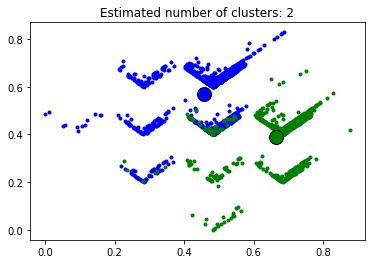

In [98]:
import matplotlib.pyplot as plt
from itertools import cycle

plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(dist[my_members, 0], dist[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

### Label Clusters in df

In [91]:
data["Cluster"] = labels

In [92]:
data.Cluster.unique()

array([0, 1])

## Cluster Evaluation

In [23]:
numerical_data = data.select_dtypes(np.number)
categorical_data = data.select_dtypes([object, "category"])

In [32]:
def cluster_summary(cluster_id):
    cluster = data['Cluster'==cluster_id]
    cluster_summary = cluster[categorical_data.columns].mode().to_dict(orient="records")[0]
    cluster_summary.update(cluster.mean().to_dict())
    cluster_summary["cluster_id"] = cluster_id
    return cluster_summary

In [93]:
cluster = data[data.Cluster==0]
cluster[categorical_data.columns].mode().to_dict(orient="records")

[{'Sex': 'Feminino', 'Payer': 'ADSE', 'Facility': 'HCD'}]

In [94]:
cluster = data[data.Cluster==1]
cluster[categorical_data.columns].mode().to_dict(orient="records")

[{'Sex': 'Masculino', 'Payer': 'ADSE', 'Facility': 'HCD'}]

In [41]:
cluster = data[data.Cluster==2]
cluster[categorical_data.columns].mode().to_dict(orient="records")

[{'Sex': 'Missing', 'Payer': 'MULTICARE', 'Facility': 'HCD'}]

In [37]:
cluster_summary(2)

KeyError: False

In [34]:
def cluster_comparison(*cluster_ids):
    summaries = []
    for cluster_id in cluster_ids:
        summaries.append(cluster_summary(cluster_id))
    return pd.DataFrame(summaries).set_index("cluster_id").T

In [35]:
cluster_comparison(0,1,2)

KeyError: False